<a href="https://colab.research.google.com/github/kvnwj/StackedLSTM-TFKeras/blob/main/Tugas_Akhir_AI_(StackedLSTM_TFKeras).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BBCA Stock Price Prediction And Forecasting Using Stacked LSTM
Tugas Akhir Mata Kuliah Artificial Intelligence


## Import Data

In [1]:
# Connect ke Google Drive
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
# cd ke direktori data saham
%cd /gdrive/'My Drive'/Data_AI
%ls

/gdrive/My Drive/Data_AI
BBCA.JK_2020.csv  BBCA.JK.csv


In [3]:
# Membaca file CSV Saham
import pandas as pd
df = pd.read_csv('BBCA.JK.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-01,26000.0,26000.0,26000.0,26000.0,25246.753906,0
1,2019-01-02,26000.0,26225.0,26000.0,26200.0,25440.958984,7191200
2,2019-01-03,26000.0,26100.0,25575.0,25900.0,25149.652344,14471600
3,2019-01-04,25875.0,26025.0,25625.0,26025.0,25271.031250,10293000
4,2019-01-07,26325.0,26625.0,26225.0,26225.0,25465.236328,14687600


In [4]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
253,2019-12-20,33400.0,33700.0,33050.0,33300.0,32734.117188,19890600
254,2019-12-23,33400.0,33650.0,33250.0,33300.0,32734.117188,9311700
255,2019-12-26,33300.0,33625.0,33300.0,33400.0,32832.417969,7637700
256,2019-12-27,33350.0,33500.0,33350.0,33475.0,32906.144531,5989000
257,2019-12-30,33400.0,33600.0,33350.0,33425.0,32856.992188,12233600


In [5]:
# Ambil hanya harga "Close" saja
df1=df.reset_index()['Close']

In [6]:
df1

0      26000.0
1      26200.0
2      25900.0
3      26025.0
4      26225.0
        ...   
253    33300.0
254    33300.0
255    33400.0
256    33475.0
257    33425.0
Name: Close, Length: 258, dtype: float64

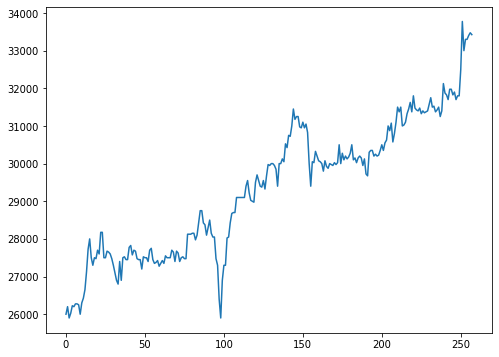

In [7]:
# Menampilkan Data menggunakan matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.plot(df1)

## Data Preprocessing

In [8]:
# LSTM is sensitive to the scale of data, to fix this we apply MinMax Scaler from sklearn

In [9]:
import numpy as np

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [11]:
# Check 10 nilai pertama df1
print(df1[0:10])

[[0.01269841]
 [0.03809524]
 [0.        ]
 [0.01587302]
 [0.04126984]
 [0.03809524]
 [0.04761905]
 [0.04761905]
 [0.04444444]
 [0.01269841]]


### Split Data

In [12]:
# Split Data into train and test split with train 65% and test 35%
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [13]:
training_size,test_size

(167, 91)

In [14]:
# Check 10 nilai pertama pada train_data
print(train_data[0:10])

[[0.01269841]
 [0.03809524]
 [0.        ]
 [0.01587302]
 [0.04126984]
 [0.03809524]
 [0.04761905]
 [0.04761905]
 [0.04444444]
 [0.01269841]]


In [15]:
# Check 10 nilai pertama pada test_data
print(test_data[0:10])

[[0.52063492]
 [0.51746032]
 [0.51428571]
 [0.52380952]
 [0.51746032]
 [0.52380952]
 [0.58412698]
 [0.52063492]
 [0.55555556]
 [0.53333333]]


### Convert array of values into a dataset matrix

In [16]:
import numpy
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [17]:
# reshape data into X=t,t+1,t+2,t+3,t+4,...,t+9 and Y=t+10
time_step = 10
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

### Reshape input to be [samples, time steps, features], which is required for LSTM

In [18]:
# Sebelum di reshape
print("Train Shape: ")
print(X_train.shape)
print(y_train.shape)
print("\nTest Shape: ")
print(X_test.shape)
print(y_test.shape)

Train Shape: 
(156, 10)
(156,)

Test Shape: 
(80, 10)
(80,)


In [19]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
y_train = y_train.reshape(y_train.shape[0],1)
y_test = y_test.reshape(y_test.shape[0],1)

In [20]:
# Setelah di reshape untuk masuk ke LSTM
print("Train Shape: ")
print(X_train.shape)
print(y_train.shape)
print("\nTest Shape: ")
print(X_test.shape)
print(y_test.shape)

Train Shape: 
(156, 10, 1)
(156, 1)

Test Shape: 
(80, 10, 1)
(80, 1)


## Design Stacked LSTM model



In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [22]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(10,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 50)            20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


## Fit Model

In [24]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=32,verbose=1)

Epoch 1/100
5/5 [==============================] - 6s 359ms/step - loss: 0.1203 - val_loss: 0.2197
Epoch 2/100
5/5 [==============================] - 0s 27ms/step - loss: 0.0370 - val_loss: 0.0094
Epoch 3/100
5/5 [==============================] - 0s 28ms/step - loss: 0.0193 - val_loss: 0.0093
Epoch 4/100
5/5 [==============================] - 0s 28ms/step - loss: 0.0119 - val_loss: 0.0599
Epoch 5/100
5/5 [==============================] - 0s 65ms/step - loss: 0.0146 - val_loss: 0.0505
Epoch 6/100
5/5 [==============================] - 0s 27ms/step - loss: 0.0102 - val_loss: 0.0138
Epoch 7/100
5/5 [==============================] - 0s 28ms/step - loss: 0.0077 - val_loss: 0.0062
Epoch 8/100
5/5 [==============================] - 0s 29ms/step - loss: 0.0072 - val_loss: 0.0177
Epoch 9/100
5/5 [==============================] - 0s 27ms/step - loss: 0.0074 - val_loss: 0.0136
Epoch 10/100
5/5 [==============================] - 0s 27ms/step - loss: 0.0070 - val_loss: 0.0031
Epoch 11/100
5/5 [

## Evaluate Model

In [25]:
import tensorflow as tf
tf.__version__

'2.4.0'

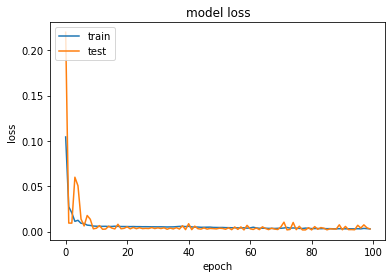

In [26]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Do the prediction

In [28]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [29]:
# Transform back to the original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

### Calculate RMSE performance metrics


In [30]:
import math
from sklearn.metrics import mean_squared_error
### Train Data RMSE
math.sqrt(mean_squared_error(y_train,train_predict))

28529.576044019548

In [31]:
### Test Data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))

30978.22228107278

### Plotting

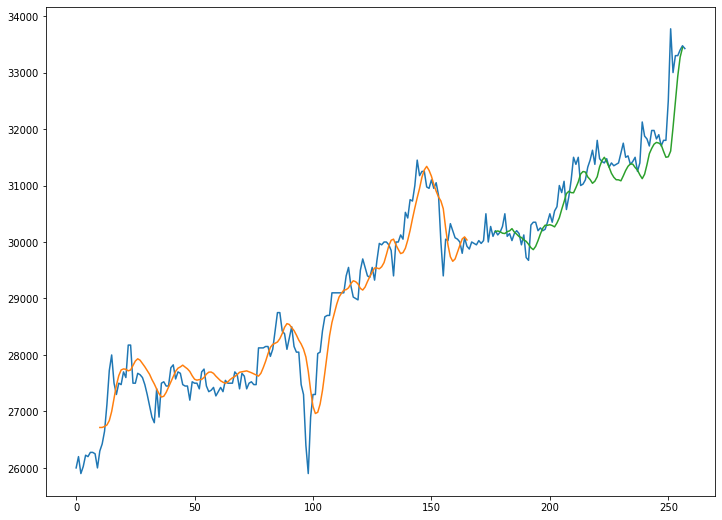

In [32]:
# shift train predictions for plotting
look_back=10
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict

# plot baseline and predictions
plt.figure(figsize=(12,9))
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## Predict Next 30 Days with Model

In [33]:
len(test_data)

91

In [34]:
# Mempersiapkan data untuk prediksi h+1 setelah data test
x_input=test_data[81:].reshape(1,-1)
x_input.shape

(1, 10)

In [35]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [36]:
# Panjang temp_input sesuai dengan time-steps
len(temp_input)

10

In [37]:
# demonstrate prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=10
i=0
# Jumlah hari yang mau diprediksi
while(i<30):
    
    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.9514714]
11
1 day input [0.74920635 0.83809524 1.         0.9015873  0.93968254 0.93968254
 0.95238095 0.96190476 0.95555556 0.95147139]
1 day output [[0.92940414]]
2 day input [0.83809524 1.         0.9015873  0.93968254 0.93968254 0.95238095
 0.96190476 0.95555556 0.95147139 0.92940414]
2 day output [[0.89633363]]
3 day input [1.         0.9015873  0.93968254 0.93968254 0.95238095 0.96190476
 0.95555556 0.95147139 0.92940414 0.89633363]
3 day output [[0.8656303]]
4 day input [0.9015873  0.93968254 0.93968254 0.95238095 0.96190476 0.95555556
 0.95147139 0.92940414 0.89633363 0.86563033]
4 day output [[0.84913546]]
5 day input [0.93968254 0.93968254 0.95238095 0.96190476 0.95555556 0.95147139
 0.92940414 0.89633363 0.86563033 0.84913546]
5 day output [[0.81032205]]
6 day input [0.93968254 0.95238095 0.96190476 0.95555556 0.95147139 0.92940414
 0.89633363 0.86563033 0.84913546 0.81032205]
6 day output [[0.77294207]]
7 day input [0.95238095 0.96190476 0.95555556 0.95147139 0.92940414 

In [38]:
day_new=np.arange(1,11) # Untuk menampung 10 hari terakhir testing
day_pred=np.arange(11,41) # Untuk menampung 30 hari hasil prediksi

In [39]:
import matplotlib.pyplot as plt

In [40]:
len(df1), len(lst_output)

(258, 30)

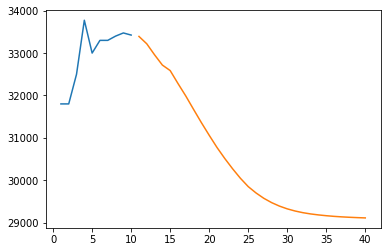

In [41]:
plt.plot(day_new,scaler.inverse_transform(df1[248:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

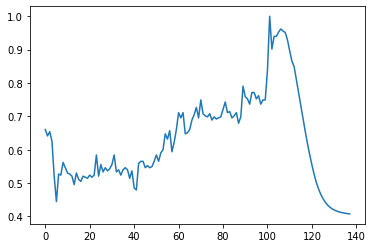

In [42]:
df3=df1.tolist()
df3.extend(lst_output)
# Plot dari data ke x sampai prediksi terakhir
x = 150
plt.plot(df3[x:])

In [43]:
df3=scaler.inverse_transform(df3).tolist()

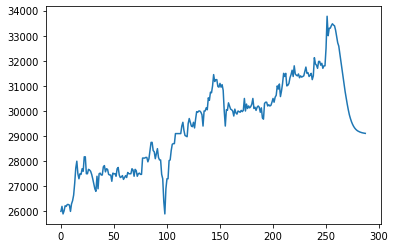

In [44]:
plt.plot(df3)

### Compare with true values

In [45]:
df2 = pd.read_csv('BBCA.JK_2020.csv')
df2_close =df2.reset_index()['Close']
df2_close

0      33450.0
1      34000.0
2      33675.0
3      33700.0
4      33400.0
        ...   
221    31925.0
222    31025.0
223    31975.0
224    32250.0
225    32300.0
Name: Close, Length: 226, dtype: float64

In [46]:
jml_hari_pred = 30
jml_hari_2019_pred = 120

day_2019=np.arange(1,1+jml_hari_2019_pred) # Untuk menampung 90 hari terakhir tahun 2019 + 30 hari prediksi
day_2020=np.arange(1+(jml_hari_2019_pred-jml_hari_pred),1+jml_hari_2019_pred) # Untuk menampung hari harga saham tahun 2020

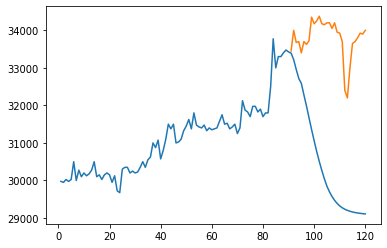

In [47]:
plt.plot(day_2019,df3[len(df3)-jml_hari_2019_pred:])
plt.plot(day_2020,df2_close[:jml_hari_pred])